<a href="https://colab.research.google.com/github/harnalashok/LLMs/blob/main/Attention%20is%20all%20that%20you%20need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 04th Jan, 2026
# Transformers
# Ref: https://learnopencv.com/attention-mechanism-in-transformer-neural-networks/
#   Transformers from scratch:
#       https://peterbloem.nl/blog/transformers
#   reddit:
#       https://www.reddit.com/r/MachineLearning/comments/qidpqx/d_how_to_truly_understand_attention_mechanism_in/
#

- First read this [article](https://peterbloem.nl/blog/transformers).       
- Then see these two videos, in sequence.



## Attention is all you need Visualizer      
See [this excellent visualization](https://poloclub.github.io/transformer-explainer/) of how Attention mechanism works.


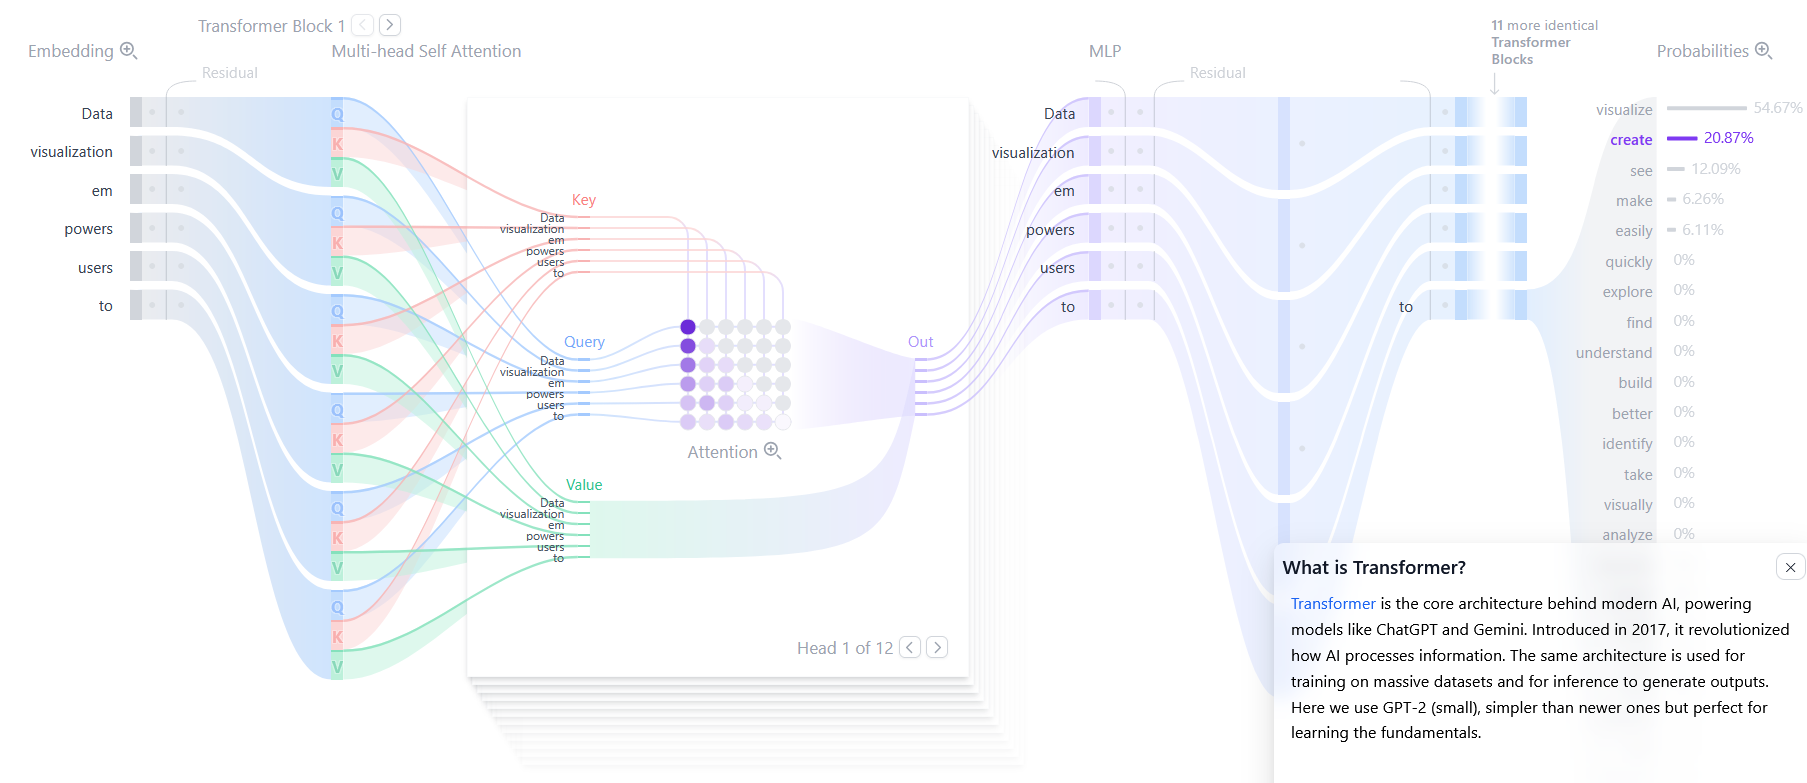

## Videos

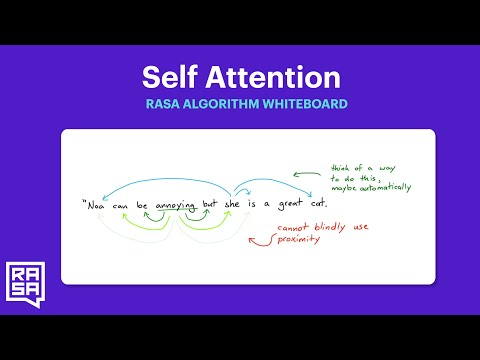

In [ ]:
# First video
from IPython.display import YouTubeVideo
YouTubeVideo('yGTUuEx3GkA')

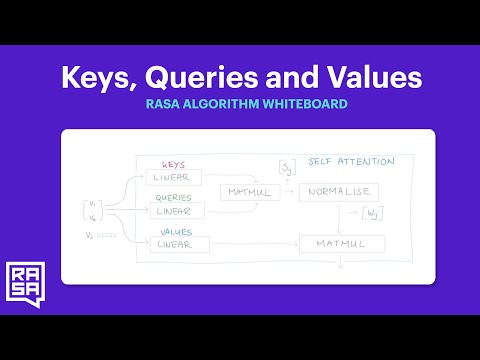

In [ ]:
# IInd video
from IPython.display import YouTubeVideo
YouTubeVideo('tIvKXrEDMhk')

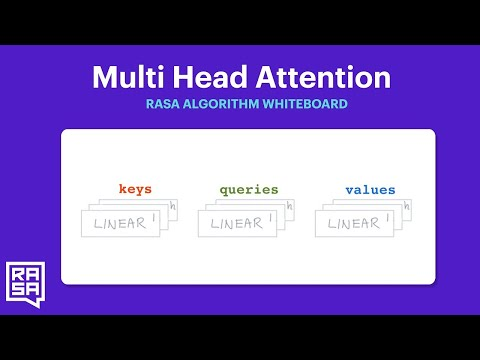

In [ ]:
# IIIrd video
from IPython.display import YouTubeVideo
YouTubeVideo('23XUv0T9L5c')

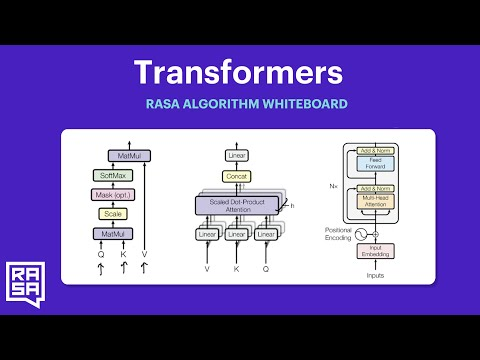

In [ ]:
# IV th video
from IPython.display import YouTubeVideo
YouTubeVideo('EXNBy8G43MM')

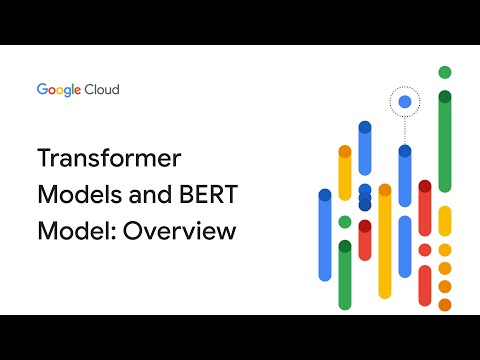

In [ ]:
# Video from google
from IPython.display import YouTubeVideo
YouTubeVideo('t45S_MwAcOw')

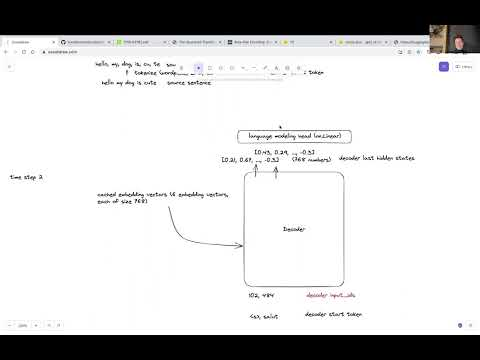

In [ ]:
# An excellent overview of how Encoder-decoder work in Vaswani's Transformer:
#  It matches with the book by Aurelien Geron (Hands-on MAchine Learning)

from IPython.display import YouTubeVideo
YouTubeVideo('IGu7ivuy1Ag')

You also learn how to use [this site](https://excalidraw.com/) for drawing.

# Attention mechanism

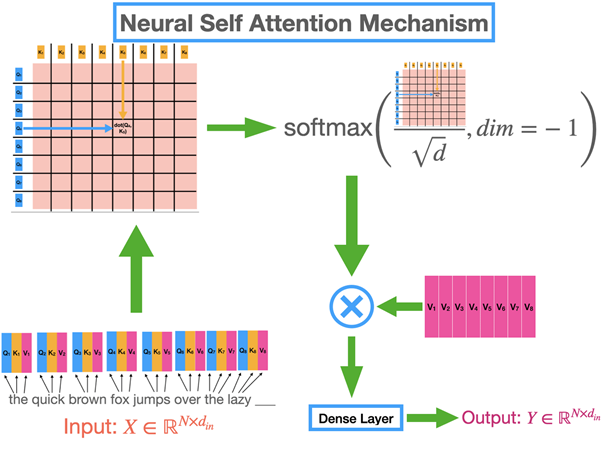

While LSTMs are designed to solve the mathematical deficiencies of RNNs, the neural self attention mechanism (or simply attention mechanism) goes back to the drawing board and rethinks the motivation behind RNNs from the beginning. While it is true that sentences are sequences of words, humans don’t process words sequentially, one after the other, but rather in chunks. Further, some words are highly relevant for predicting the next word, but most are not.

An LSTM is forced to process all words sequentially regardless of their relevance, which restricts what the model can learn. Is there a mechanism by which we can allow the model to incorporate the relevance of specific words within itself?

In other words, which previous words should we pay attention to when predicting the next word? This is the motivating question behind the origin of the attention mechanism. It turns out that the answer is not only relevant for language models but also led to the development of ViTs.

Rather than sequences, the attention mechanism processes inputs as chunks without any explicit temporal connection. Let us see how it works step by step in the context of modeling the next word in a sentence.

### Step 1

Step 1, Query, key value: Much like RNNs, each word in the sentence ‘emits’ a hidden representation of itself. To allow the mechanism to model relevance, we let each word ask questions and receive answers.

When the question asked by a word matches the answer sent by another word, we will interpret this as the two words having high relevance for each other. A word asks the same question to all words in the sequence using the ‘query’ vector. Similarly, it provides the same answer to all words using the ‘key’ vector.

In the most commonly used variant of the attention mechanism, a separate ‘value’ vector is also used to allow the model to combine the outputs of query and key vectors non-linearly. This increases the expressivity of the model. All three types of vectors are outputs of their separate dense layers, and all three types have the same size, say, d. To summarize, in step 1 of the attention mechanism, as shown in figure 3, each word in the sentence emits three separate representations of itself, called the query Q, key K, and value V vectors using three separate dense layers.



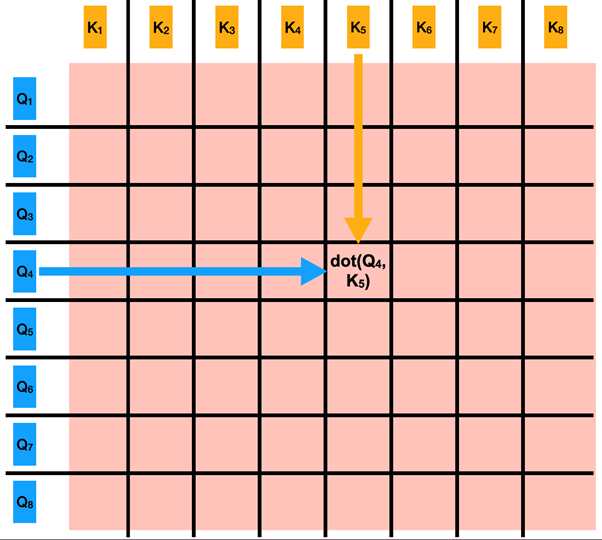

### Step 2


Computing the Attention Matrix: If we are modeling a sentence with N words, then after step 1, we have N query, N key and N value vectors. So, how exactly does a word ask questions and get answers? This is done by the attention matrix, which is the core of the attention mechanism. We take the dot product of all the N query vectors with all the N key vectors, as shown in figure 4. Since the dot product of two vectors (no matter how large) is just a number, the result of these NxN dot products is an NxN matrix A, whose each element A_{ij} is the dot product of the i-th query vector with the j-th key vector. There are three important things to note here:

>1. Firstly, since each word interacts with every other word while computing the attention matrix, there is no temporal ordering to the inputs. Thus, the vanilla attention mechanism does not consider the sequential nature of inputs.
>2. Second, the computational complexity of calculating the attention matrix is N^2. Thus, if we want to model a sentence with twice the number of words, it will take 4x the computational resources. This will become important in the next part of this series when we build the vision transformer model.
>3.Thirdly, we note that the ‘self’ in self attention refers to the fact that we also take the dot product of a given word’s query with its own key vector. There are some early variants of the attention mechanism which skip computing self relevance, resulting in output with NxN – N elements (all the diagonal elements of the matrix are missing). However, the self attention variant works best and is highly parallelizable on modern GPUs. This is where this mechanism gets the name self attention.

### Step 3

Normalization And Attention Scores: The attention matrix, as computed above, will contain some large and some small numbers. We will interpret the large numbers as representing high relevance and the small relevance as low relevance.

At this point there are several ways in which we could use this matrix. We could pick out the maximum element in each row using the max pooling operation and use them for further processing. However, this throws away most of the information. Moreover, sometimes a given word may need context from multiple previous words to correctly model the data. Thus, we should maintain expressivity as much as possible. Another important requirement is that however, we choose to use the attention matrix, it should maintain the differentiability of the model since the model needs to be trainable with back propagation.

All these requirements are met by the softmax layer. Thus, we take a row-wise softmax of the attention matrix, resulting in an NxN matrix whose each row is a probability distribution. A small implementation detail here is that before taking the softmax, we divide the attention matrix by the square root of the dimension of each query vector. This acts as a suitable scaling factor to ‘soften’ the resulting probability distribution.



After scaling, the differences between large and small probability values are reduced and gradients can flow relatively equally into multiple word positions. This is similar to how knowledge distillation algorithms incorporate ‘temperature’ into the logits from the teacher model. Just like in the domain of knowledge distillation, scaling the input to softmax by the temperature factor improves gradient flow and allows faster training. We will see in the next post that this is one of the key reasons behind the success of vision transformers.

Attend: We take the dot product of the normalized attention scores obtained in the previous step with the value vectors. Mathematically, this is represented as




image.png

Since the value vector V was obtained for each word using a dense layer, the output of the attention mechanism has N vectors, the same as the number of input words. Finally, to obtain the output of the self attention layer, we transform the h vector into the same size as the input with a dense layer. In the above equation, the circular symbol represents the dot product, not the matrix multiplication. In terms of matrix multiplication, the operation could depend on how the query and key vectors are shaped. We will make the notation more concrete in the coming section.

## Multi Headed Self Attention

You are likely quite familiar with convolutional networks. The convolution operation is the fundamental building block of CNNs. Similarly, the self attention mechanism introduced above is the fundamental building block of all transformer models, both large language models, and vision transformers.

Continuing with the analogy, one would never design a convolutional layer with just one convolution filter since one filter is insufficient to model the complexity in natural images. Indeed it is quite common to see convents with >500 convolutional filters in one layer. Similarly, one single attention layer, as described above is insufficient to model all the complexities of natural language.

Therefore, we apply multiple attention blocks, called ‘heads’ in parallel to the same sequence. The resulting layer is called Multi Headed Self Attention (MHSA). The difference from convolutions is that one attention head is much more expressive than a single convolution filter. Thus, we don’t need to use ~500 attention heads, but just a few dozen would do. Some common choices for the number of attention heads in ViTs are 12, 24, and 32. Another difference from convolutions is that in CNNs the number of filters increases in each subsequent layer, while the number of attention heads in the most popular ViTs is usually constant, say 12.

To summarize, the self attention mechanism goes beyond dense layers, convolutional layers and LSTM cells and proposes an entirely new general computing mechanism to model relationships in the data. In NLP, the data has a sequential nature but in computer vision, it may not. Yet, in the next part of this series, we will see that vision transformers built using the attention mechanism work quite well for computer vision applications.

## An explanation of self-attention from reddit
See [here](https://www.reddit.com/r/MachineLearning/comments/qidpqx/comment/hij89tt/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button)

Here's the metaphor I use.

><i>First, think about a matchmaking process, like online dating, matching buyers to sellers, etc.. I have a profile that talks about me -- it's not *me* or all the information about my whole life, it's information about me and what I have to offer with respect to some particular thing. That's my Key. "Male, 5'10", and like to swim." "500 pounds of firewood, can deliver." When I first started out dating/selling/whatever, I had no idea how to craft a profile and was getting really random matches, but over time, I've learned how to craft that information so that, together, we achieve some end goal. That's learning W_k.

>Meanwhile, however, the people on the other side of the transaction are offering up descriptions of what they *want*. "Fit male taller than 5'8"." "100 pounds of bricks." That's their Query. Again, it's not them or their life story, it's information about what they need, and likewise they've learned over time to craft the request to better achieve some end goal.

>So what attention is doing is comparing these what-I-gots to what-I-needs, and giving a score of how well all possible matches would be. Then that score is used to aggregate a Value. To explain values (and heads), I'm going to narrow the metaphor a bit. I just wanted to use dating and firewood to make it a little more concrete. Now we're going to shift to asking for and receiving information (because I can talk about aggregating this, whereas I can't easily talk about a weighted average of firewood and bricks).

>Now imagine that I work at a council of experts, sitting around the big meeting table with 50 coworkers (me included). Each of us has a lot of expertise in various things, but we're all quite different. Say I need information about cars, specifically Japanese ones because I have a question about my Toyota. I first describe what I want, ideally, in an expert -- that they're a mechanic with so many years of experience, they work on, own, or drive Japanese cars, etc. Meanwhile, each of my 50 coworkers (including me) publishes their own credentials with respect to cars (their key), and also an opinion (their value). "I'm a Ford mechanic; after about 10 years expect to see exhaust problems." "I know nothing about cars except that I know how to drive; blue is the best color for a car."

>Remember that all of us is publishing three pieces of information with respect to cars: our expertise (key), our need for expertise (query), and our opinion (value). These aren't all the same thing, although they're all calculated *from* the same thing (my personal profile considered as a whole). (They could be the same thing, if we decided they had to be; some Transformer architectures don't calculate all three, but (say) reuse Keys as Queries. But in the original, these are three different things.) Also note that my fellow employees and I share the same way of writing keys/queries/values (we don't each have our own W_k, W_q, W_v.); we just end up different values of K, Q, and V because we're starting from different information. (That's why our organization can scale up to more employees; we're learning a process-of-writing, not learning different weights all individually.)

>The purpose of attention is to gather all of these opinions (values) and aggregate them, the way it does this is by taking the similarity of my query (what I want in an expert) and each expert's key (what they advertise about themselves as an expert), and using the resulting similarity numbers to calculate a weight according to how much I should include that expert's opinion (value) in my final aggregate opinion. We could do something simple, like just divide each number by the sum of all the numbers, but empirically we've found it's better to do the scale & softmax thing. I add up everyone's information according to how much attention I paid them, and that gives me a nuanced opinion relevant to my needs. (Or it does *now*, when we started out we were pretty terrible at this and got largely random results, but we got a little better every time.)

>Now, remember that all of my coworkers are *also* making queries with respect to car expertise, and aggregating the information according to *their* needs. We do the whole 50-by-50 comparison. Someone needs information about American cars; they'll end up paying more attention to the Ford expert, but neither of us will pay much attention to the know-nothing guy.

>Also, cars aren't the only things we talk about. We actually have 16 different subjects that we discuss. And each of those topics has completely different keys/values/queries from cars. "I'm looking for an expert on Italian food; I'm an expert on Thai food; make sure every dish has a balance of flavors." It turns out that guy who likes blue is an expert on Italian food, so for this purpose I pay him a lot of attention and weight his contribution highly. These different subjects are the different heads. So really we're doing 50-by-50-by-16 comparisons. (And note, these discussion subjects aren't pre-determined. Discussion 3 wasn't originally about cars and discussion 11 wasn't originally about food; all of our discussions were originally random, and eventually came to be about cars and food because, in the big picture, the more we talked about cars and food in these discussions the better we achieved our end goal.)

>At the end, my knowledge is the added-up value of all of these 16 results. And we do this process many times (gone through many layers) -- on stage 7 I a lot more than at the beginning, in fact, I now know a lot about Japanese cars and Italian food myself, and advertise myself that way. Our expertise is now more distributed across the team -- not evenly, taking everybody's opinion into account equally, or randomly, but by trying to match experts to needs. (Or, in reality, I'm not really the *same* employee I was at early stages... I'm being sloppy about identity here to tell a story. You could imagine I'm now the 7th generation of employee in this process, or an employee on the 7th floor -- I have special access to my 6th-level predecessor's files (a residual connection) but I'm not them, I have the weights of a 7th-level employee.)

>Now let's apply this metaphor to, say, machine translation. Now "we" are nodes representing tokens in the encoder of a machine translation system. We're translating from Turkish to English, and I'm representing the gender-neutral 3rd person pronoun. Part of our collective end goal is to figure out which English gender to assign to this pronoun in the output. So in one of our discussions, I put out a query, "I'm in need of a gender expert". The person representing the word for "father" says "I'm gendered (key); my opinion is masculine (value)"; the person representing the word for "dance" says "I'm not gendered (key); my opinion is feminine (value)." In trying to form my own aggregate opinion of the gender that we should eventually output, I pay more attention to the opinion of the gendered words in the sentence. If gender ends up being very important to the translation task and one particular discussion ends up being more successful at solving these, we may find that this entire discussion slowly becomes entirely about gender.

>But of course, making a decision about a particular pronoun isn't just aggregating all the gender information in the whole sentence -- if I'm a plural pronoun and the word for "father" is singular, it's probably not what my pronoun is referring to, so we don't just have to discuss gender, we have to discuss plurality, maybe case, etc. I have to make queries about a variety of aspects of words in order for us, collectively, to come to the right answer. And we have to do this a bunch of times (layers); this isn't a once-and-done. What information we've aggregated, what discussions we have, and what expertise we're looking for, will be quite different on layer 2 and on layer 7. On layer 2 I'm still largely asking "Hey who's gendered?"; by layer 7 I might be asking "what's the gender of the instrumental object of the verb?"

>Anyway, hope this helps! It's a bit sloppy in places, and any description of what is "really" going inside of a Transformer in terms of human categories is probably wishful thinking, but my coworkers and I found this to be a helpful metaphor to help us think about the general algorithm.</i>

In [ ]:
############# DONE ###############